In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))
import pandas as pd
import matplotlib.pyplot as plt
import logging

In [2]:
from utils.read import read_csv_files
from pyspark.sql.functions import sum, count, col,to_date, month, year, first

In [3]:
%cd /spark-data/capstone_crm/utils
%run 'logger_setup.ipynb'

/.local/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/spark-data/capstone_crm/utils


In [4]:
# Define the path variable
CLEANED_DATA_PATH = "/spark-data/capstone_crm/data/cleaned/"
logging.info("PRODUCT SALES PERFORMANCE ANALYSIS.......")

2024-09-09 05:54:36,100 - INFO : PRODUCT SALES PERFORMANCE ANALYSIS.......


In [5]:
try:
    logging.info("reading csv files")   
    # read products data
    products_df = read_csv_files(f"{CLEANED_DATA_PATH}products.csv")
    # read transactions data
    transactions_df = read_csv_files(f"{CLEANED_DATA_PATH}transactions.csv")
except Exception as e:
    logging.error("Error in loading files :{e}", exc_info=True) 

2024-09-09 05:54:36,130 - INFO : reading csv files
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/09 05:54:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/09 05:54:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/09/09 05:54:41 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/09/09 05:54:41 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


# Product Sales Performance Analysis

###  Top products on revenue

2024-09-09 06:09:28,955 - INFO : Top 10 products on total revenue


+----------+------------+------+------------------+------------+
|Product_ID|Product_Name| Price|     Total_Revenue|Sales_Volume|
+----------+------------+------+------------------+------------+
|         1|         him| 411.0| 8207.780163599182|          27|
|         2|         why| 333.0| 6699.780163599182|          24|
|         3|    strategy| 645.0|4563.3404907975455|          17|
|         4|   interview| 290.0|            4717.0|          14|
|         5|      though|1738.0|            6561.0|          23|
|         6|     process|1449.0|            3516.0|          13|
|         7|      charge|1177.0| 6230.560327198364|          21|
|         8|  understand|1585.0|            5048.0|          17|
|         9|      number|1868.0| 6588.780163599182|          24|
|        10|        what| 243.0|            8104.0|          27|
|        11|       again|1050.0|            7486.0|          24|
|        12|       place| 223.0| 5682.560327198364|          18|
|        13|         out|

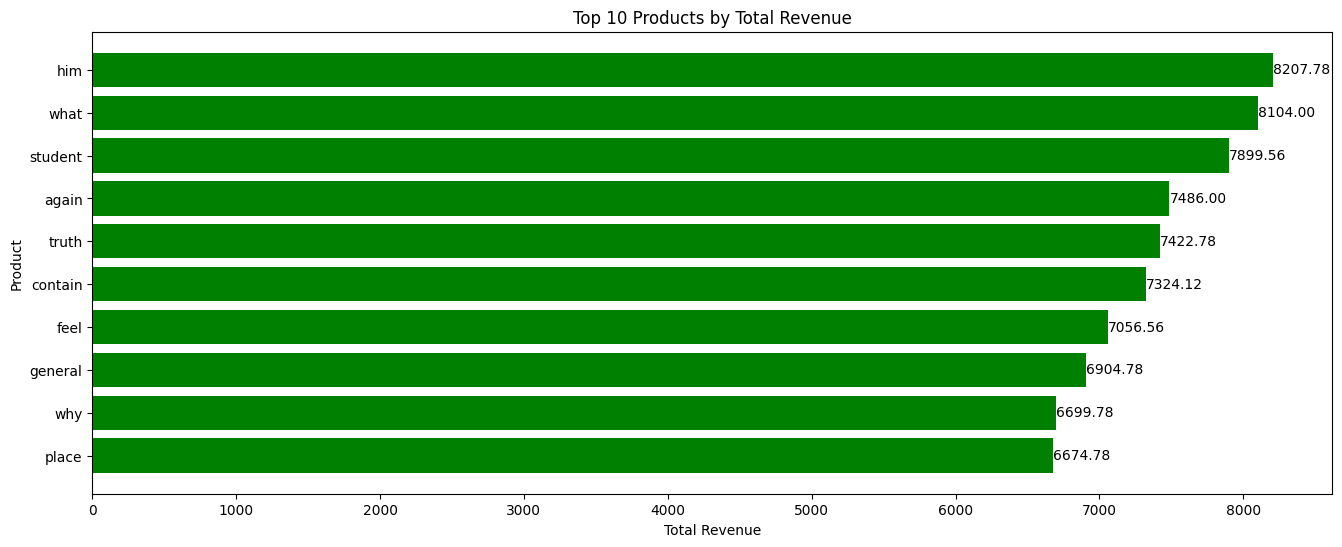

In [18]:
try:    
    # Calculate total revenue for each product
    logging.info("Top 10 products on total revenue")
    product_sales_df = transactions_df.join(products_df,"Product_ID", "inner")
    products_revenue_df = product_sales_df.groupBy("Product_ID").agg(
        first("Product_Name").alias("Product_Name"),
        first("Price").alias("Price"),
        sum("Amount").alias("Total_Revenue"),
        count("*").alias("Sales_Volume")
    )
    products_revenue_df.select("Product_Name","Total_Revenue").orderBy("Total_Revenue",ascending = False)
    products_revenue_df.show()
    
    products_revenue_pd = products_revenue_df.orderBy("Total_Revenue",ascending = False).limit(10).toPandas()
 
    # Plot
    plt.figure(figsize=(16, 6))
    bars = plt.barh(products_revenue_pd['Product_Name'], products_revenue_pd['Total_Revenue'], color='green')
    
    # Add total revenue at the end of the bars
    for bar, total_revenue in zip(bars, products_revenue_pd['Total_Revenue']):
        plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2,
                f'{total_revenue:.2f}', va='center')
    
    plt.xlabel('Total Revenue')
    plt.ylabel('Product')
    plt.title('Top 10 Products by Total Revenue')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest revenue at the top
    plt.show()
except Exception as e:
    logging.error("invalid operation performed :{e}", exc_info=True)     

### Top product on Sales Volume

2024-09-09 05:54:52,926 - INFO : Top 10 products on sales volume


+------------+------------+
|Product_Name|Sales_Volume|
+------------+------------+
|     student|          28|
|         him|          27|
|        what|          27|
|       place|          26|
|        stay|          25|
|     contain|          25|
|       again|          24|
|         why|          24|
|      number|          24|
|      really|          24|
+------------+------------+
only showing top 10 rows



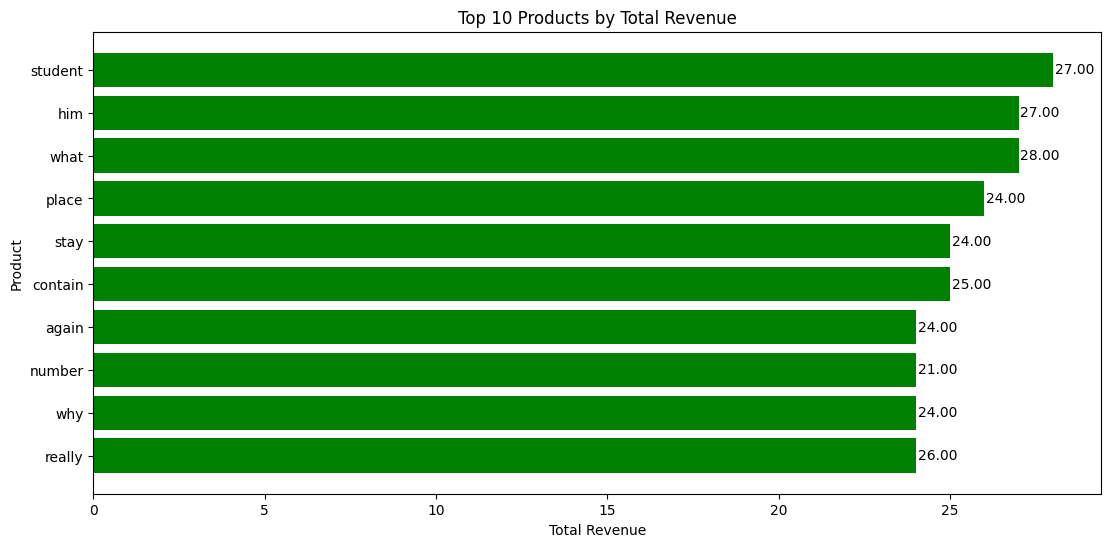

In [7]:
try:    
    # Calculate total revenue and sales volume for each product
    logging.info("Top 10 products on sales volume")
    product_volume_df = products_revenue_df.select("Product_Name","Sales_Volume")
    product_volume_df.orderBy(col("SAles_Volume").desc()).show(10)

    products_volume_pd = product_volume_df.orderBy("Sales_Volume",ascending = False).limit(10).toPandas()

    # Plot
    plt.figure(figsize=(13, 6))
    bars = plt.barh(products_volume_pd['Product_Name'], products_volume_pd['Sales_Volume'], color='green')
    
    # Add volume at the end of the bars
    for bar, volume in zip(bars, products_revenue_pd['Sales_Volume']):
        plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height() / 2,
                 f'{volume:.2f}', va='center')
    
    plt.xlabel('Total Revenue')
    plt.ylabel('Product')
    plt.title('Top 10 Products by Total Revenue')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest revenue at the top
    plt.show()
except Exception as e:
    logging.error("invalid operation performed :{e}", exc_info=True)     

### Category wise total revenue

2024-09-09 05:54:54,691 - INFO : Category wise total revenue


+-----------+------------+----------------------+
|   Category|Product_Name|Category_Total_Revenue|
+-----------+------------+----------------------+
|       Home|         him|     82767.70245398773|
|Electronics|     because|     77488.92229038857|
|   Clothing|        same|     61273.58179959101|
|     Beauty|      really|     47644.80163599183|
|    unknown|        type|    14984.560327198364|
+-----------+------------+----------------------+



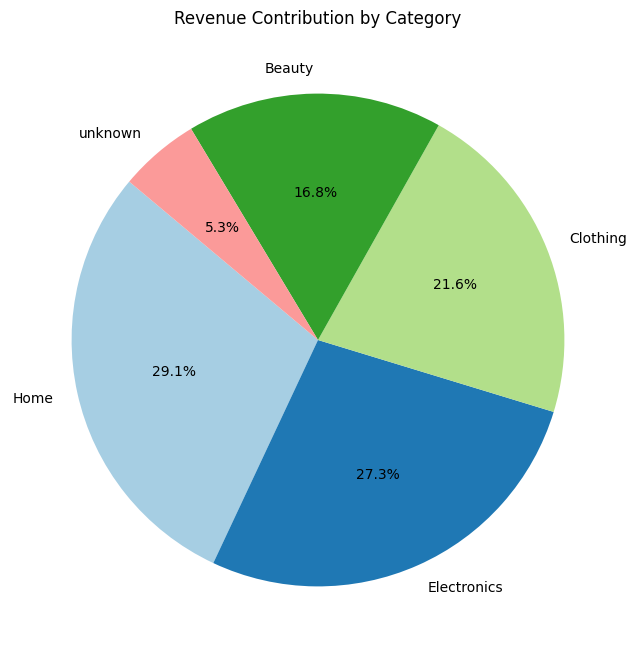

In [8]:
try:    
    # Calculate total revenue by category
    logging.info("Category wise total revenue")
    category_performance_df = product_sales_df.groupBy("Category").agg(
        first("Product_Name").alias("Product_Name"),
        sum("Amount").alias("Category_Total_Revenue"),
        count("*").alias("Category_Sales_Volume")
    )
    category_revenue_df = category_performance_df.select("Category","Product_Name","Category_Total_Revenue").orderBy("Category_Total_Revenue",ascending=False)
    category_revenue_df.show()

    # Convert category performance data to Pandas DataFrame
    category_revenue_pd = category_revenue_df.toPandas()

    # Plot
    plt.figure(figsize=(8, 8))
    plt.pie(category_revenue_pd['Category_Total_Revenue'], labels=category_revenue_pd['Category'],
            autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
    plt.title('Revenue Contribution by Category')
    plt.show()
except Exception as e:
    logging.error("invalid operation performed :{e}", exc_info=True)     



### Calculate sales volume by category

2024-09-09 05:54:56,710 - INFO : Sales volume by Category


+-----------+------------+---------------------+
|   Category|Product_Name|Category_Sales_Volume|
+-----------+------------+---------------------+
|       Home|         him|                  289|
|Electronics|     because|                  279|
|   Clothing|        same|                  214|
|     Beauty|      really|                  170|
|    unknown|        type|                   52|
+-----------+------------+---------------------+



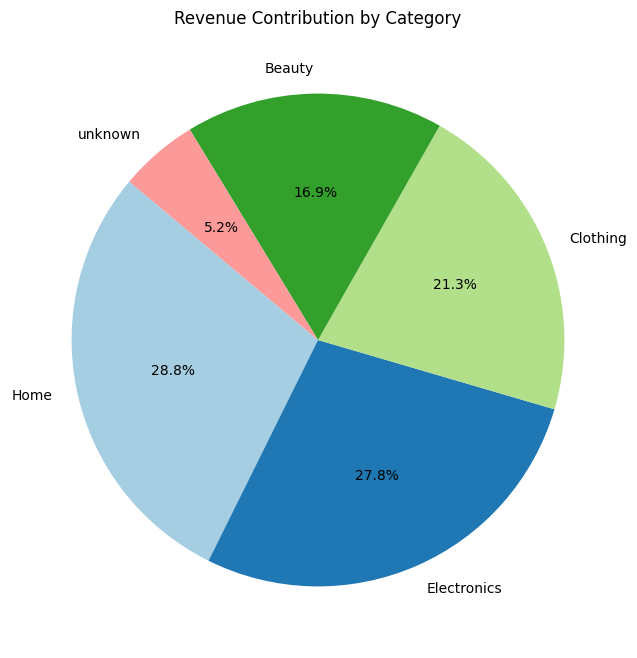

In [9]:
try:        
        # Calculate sales volume by category
        logging.info("Sales volume by Category")
        category_volume_df = category_performance_df.select("Category","Product_Name","Category_Sales_Volume") \
                             .orderBy(col("Category_Sales_Volume").desc())
        category_volume_df.show()

        # Convert category performance data to Pandas DataFrame
        category_volume_pd = category_volume_df.toPandas()

        # Plot
        plt.figure(figsize=(8, 8))
        plt.pie(category_volume_pd['Category_Sales_Volume'], labels=category_volume_pd['Category'],
                autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
        plt.title('Revenue Contribution by Category')
        plt.show()
except Exception as e:
    logging.error("invalid operation performed :{e}", exc_info=True) 

### Identify least-selling products on total revenue

2024-09-09 05:54:57,890 - INFO : Least 10 selling products on total revenue


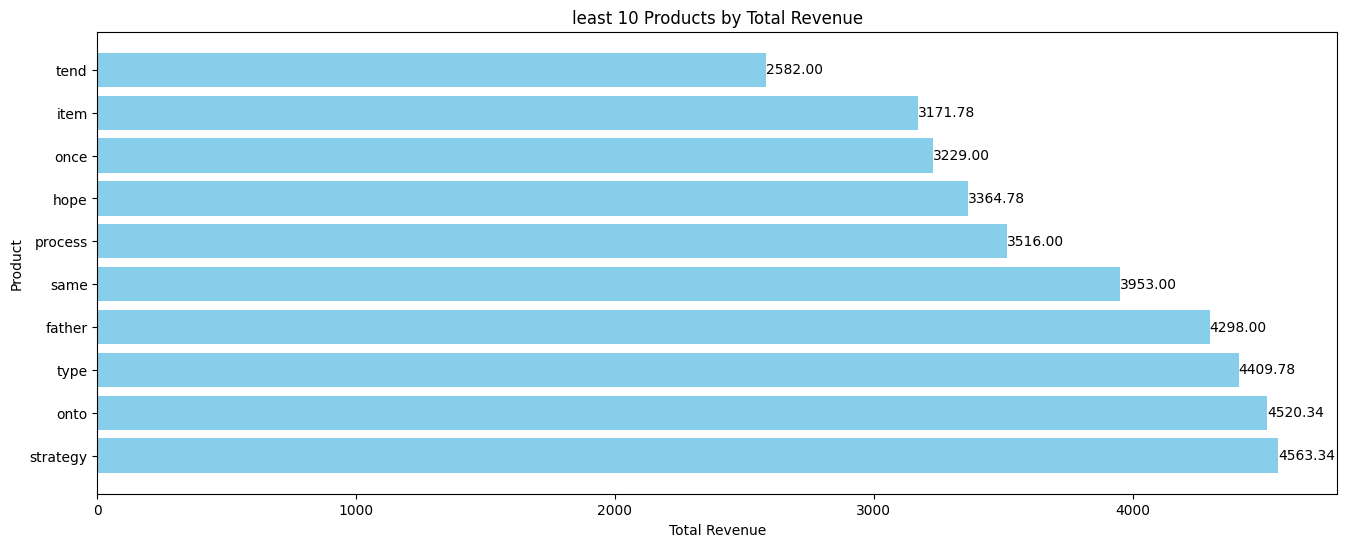

In [10]:
try:    
    # Identify least-selling products by total revenue
    logging.info("Least 10 selling products on total revenue")
    least_selling_products_df = products_revenue_df.orderBy(col("Total_Revenue"))

    # Convert the least 10 products by revenue to Pandas DataFrame
    least_selling_products_pd = least_selling_products_df.limit(10).toPandas()

    # Plot
    plt.figure(figsize=(16, 6))
    bars = plt.barh(least_selling_products_pd['Product_Name'], least_selling_products_pd['Total_Revenue'], color='skyblue')
    
        # Add total revenue at the end of the bars
    for bar, total_revenue in zip(bars, least_selling_products_pd['Total_Revenue']):
        plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height() / 2,
                f'{total_revenue:.2f}', va='center')
    
    plt.xlabel('Total Revenue')
    plt.ylabel('Product')
    plt.title('least 10 Products by Total Revenue')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest revenue at the top
    plt.show()
except Exception as e:
    logging.error("invalid operation performed :{e}", exc_info=True)     

### Identify least-selling products on sales volume

2024-09-09 05:54:58,634 - INFO : least 10 products on sales volume


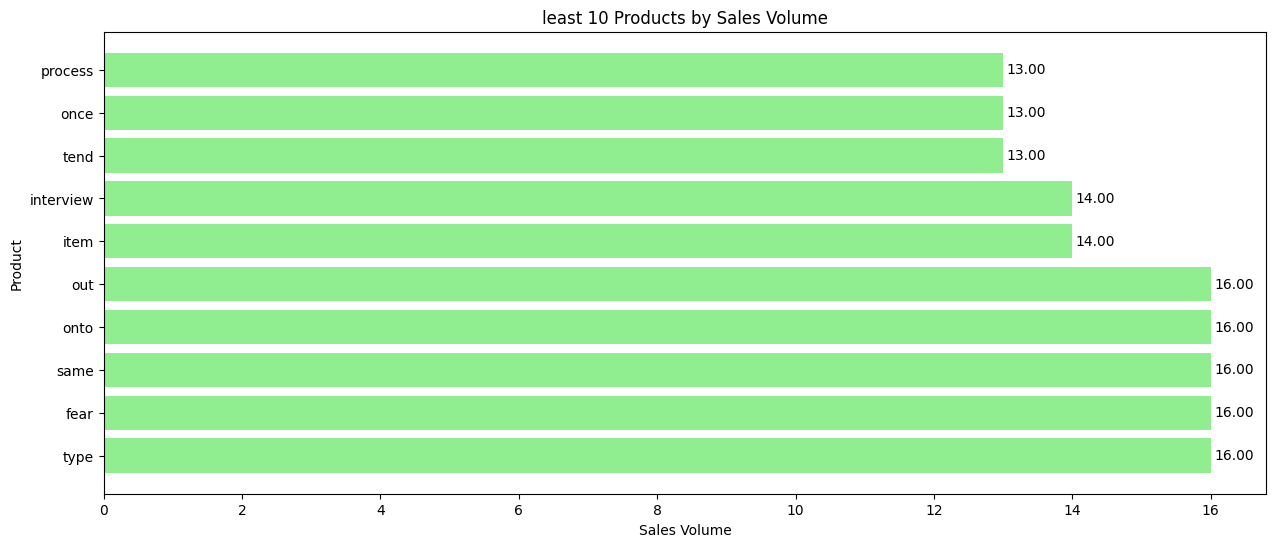

In [11]:
try:    
    # Identify least-selling products by sales volume
    logging.info("least 10 products on sales volume")
    least_selling_products_by_volume_df = products_revenue_df.orderBy(col("Sales_Volume"))

    # Convert the top 10 products by revenue to Pandas DataFrame
    least_selling_products_by_volume_pd = least_selling_products_by_volume_df.limit(10).toPandas()

    # Plot
    plt.figure(figsize=(15, 6))
    bars = plt.barh(least_selling_products_by_volume_pd['Product_Name'], least_selling_products_by_volume_pd['Sales_Volume'], color='lightgreen')
    
    # Add total volume at the end of the bars
    for bar, volume in zip(bars,least_selling_products_by_volume_pd['Sales_Volume']):
        plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height() / 2,
                f'{volume:.2f}', va='center')
    
    plt.xlabel('Sales Volume')
    plt.ylabel('Product')
    plt.title('least 10 Products by Sales Volume')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest revenue at the top
    plt.show()
except Exception as e:
    logging.error("invalid operation performed :{e}", exc_info=True)     

### correlation between price and sales volume

2024-09-09 05:54:59,484 - INFO : Correlation between price and sales volume


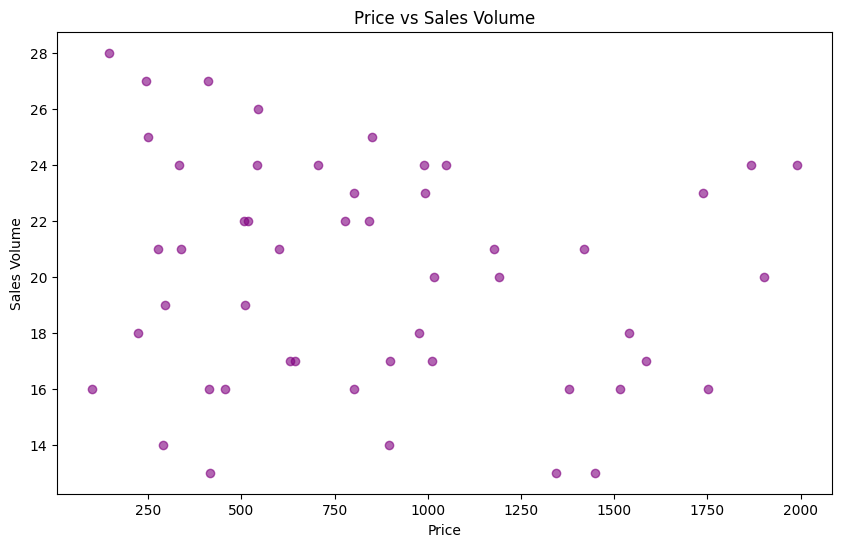

In [12]:
try:    
    # Analyze the correlation between price and sales volume
    logging.info("Correlation between price and sales volume")
    price_sensitivity_df = products_revenue_df.withColumn("Price", col("Price"))
    # Calculate correlation between price and sales volume
    price_volume_correlation = price_sensitivity_df.stat.corr("Price", "Sales_Volume")
    
    # Convert the product sales data to Pandas DataFrame
    price_sensitivity_pd = price_sensitivity_df.toPandas()

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(price_sensitivity_pd['Price'], price_sensitivity_pd['Sales_Volume'], alpha=0.6, color='purple')
    plt.xlabel('Price')
    plt.ylabel('Sales Volume')
    plt.title('Price vs Sales Volume')
    plt.show()
except Exception as e:
    logging.error("invalid operation performed :{e}", exc_info=True)     

### Calculate the percentage contribution of product to total revenue

2024-09-09 05:55:00,860 - INFO : Top 10 products contributing to total revenue


+------------+----------------------------+
|Product_Name|Revenue_Contribution_Percent|
+------------+----------------------------+
|         him|           2.888440535970354|
|        what|           2.851918745011705|
|     student|          2.7799733680266305|
|       again|           2.634435306658147|
|       truth|          2.6121873011685044|
|     contain|          2.5774675450396627|
|        feel|          2.4833090661948356|
|     general|           2.429895357694163|
|         why|           2.357752793191769|
|       place|          2.3489549194719648|
+------------+----------------------------+
only showing top 10 rows



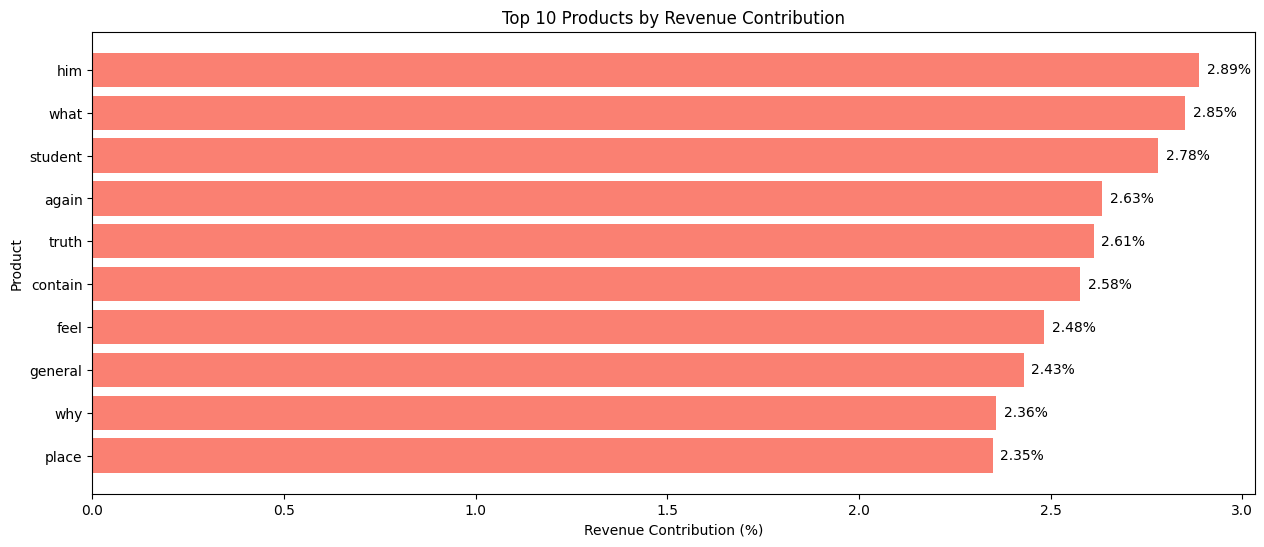

In [13]:
try:
    # Calculate the percentage contribution of each product to total revenue
    logging.info("Top 10 products contributing to total revenue")
    total_revenue = products_revenue_df.agg(sum("Total_Revenue")).first()[0]

    product_contribution_df = products_revenue_df.withColumn(
        "Revenue_Contribution_Percent",
        (col("Total_Revenue") / total_revenue) * 100
    )
    product_contribution_df = product_contribution_df.select("Product_Name", "Revenue_Contribution_Percent").orderBy(
        col("Revenue_Contribution_Percent").desc()
    )
    product_contribution_df.show(10)
    
    # Convert to Pandas DataFrame
    product_contribution_pd = product_contribution_df.limit(10).toPandas()

    # Plot
    plt.figure(figsize=(15, 6))
    bars = plt.barh(product_contribution_pd['Product_Name'], product_contribution_pd['Revenue_Contribution_Percent'], color='salmon')
    
    plt.xlabel('Revenue Contribution (%)')
    plt.ylabel('Product')
    plt.title('Top 10 Products by Revenue Contribution')
    plt.gca().invert_yaxis()

    # Add total contribution percentage at the end of the bars
    for bar, percent in zip(bars, product_contribution_pd['Revenue_Contribution_Percent']):
        plt.text(bar.get_width()+0.02, bar.get_y() + bar.get_height() / 2,
                f'{percent:.2f}%', va='center')

    plt.show()

except Exception as e:
    logging.error(f"Invalid operation performed: {e}", exc_info=True)


### Monthly sales patterns

2024-09-09 05:55:02,411 - INFO : Monthly sales patterns


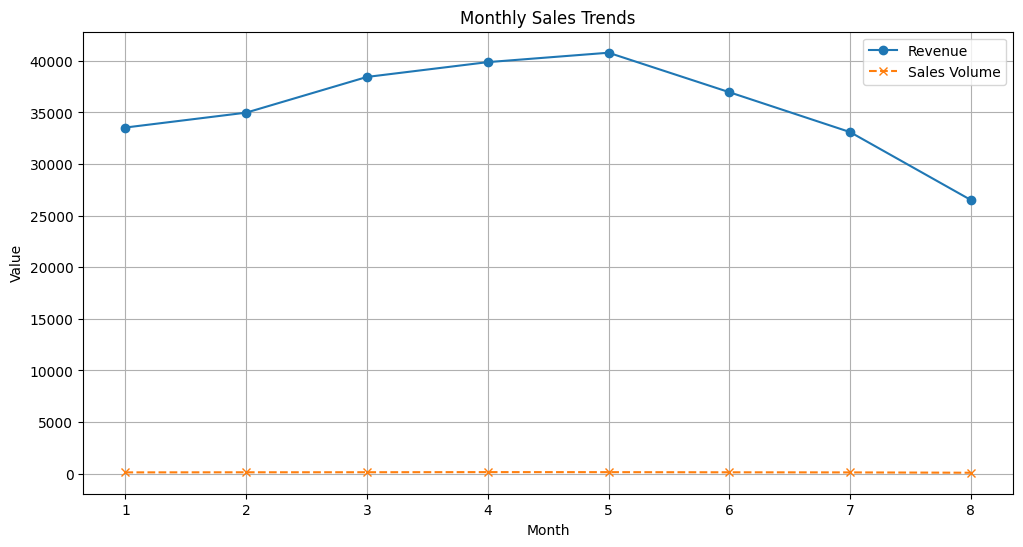

In [14]:
try:
    # Monthly sales patterns
    # Convert the Date column to a proper date type
    logging.info("Monthly sales patterns")
    transactions_df = transactions_df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))

    # Analyze sales trends by month and year
    monthly_sales_df = transactions_df.groupBy(year("Date").alias("Year"), month("Date").alias("Month")).agg(
        sum("Amount").alias("Monthly_Revenue"),
        count("*").alias("Monthly_Sales_Volume")
    ).orderBy("Year", "Month")

    # Convert the monthly sales data to Pandas DataFrame
    monthly_sales_pd = monthly_sales_df.toPandas()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_sales_pd['Month'], monthly_sales_pd['Monthly_Revenue'], marker='o', label='Revenue')
    plt.plot(monthly_sales_pd['Month'], monthly_sales_pd['Monthly_Sales_Volume'], marker='x', label='Sales Volume', linestyle='--')
    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.title('Monthly Sales Trends')
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    logging.error("invalid operation performed :{e}", exc_info=True) 